#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [8]:
df_stock1 = pd.read_csv("./data/cba.csv")#,index_col="Date",parse_dates=True)
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].dt.date
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,26.088652,26.088652,26.088652,26.088652,7.993308,0
1,4/01/2000,26.058813,26.058813,25.720646,25.790268,7.901886,1018072
2,5/01/2000,25.353634,25.392424,25.113932,25.213392,7.725136,2191283
3,6/01/2000,25.362585,25.362585,24.666357,24.716087,7.572770,1505531
4,7/01/2000,24.913021,25.113932,24.735979,24.964741,7.648952,1414040


<AxesSubplot:>

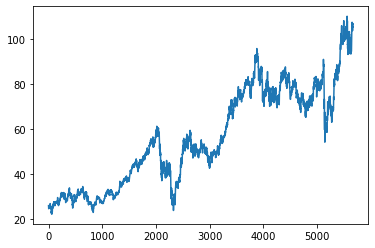

In [9]:
df["Close"].plot()

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5675 entries, 0 to 5676
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5675 non-null   object 
 1   Open       5675 non-null   float64
 2   High       5675 non-null   float64
 3   Low        5675 non-null   float64
 4   Close      5675 non-null   float64
 5   Adj Close  5675 non-null   float64
 6   Volume     5675 non-null   float64
 7   SENTIMENT  5675 non-null   object 
dtypes: float64(6), object(2)
memory usage: 399.0+ KB


In [4]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5674, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [214]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4540, 1)

In [215]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.04184307, 0.03844119, 0.03186422, 0.02619443, 0.02902934,
       0.03583307, 0.03112717, 0.0329982 , 0.03073027, 0.03450637,
       0.0379876 , 0.03712579, 0.03129727, 0.03469913, 0.03390536,
       0.03469913, 0.0329982 , 0.0329982 , 0.03776081, 0.04218326,
       0.04036892, 0.03544755, 0.03531146, 0.03016329, 0.03424555,
       0.03549291, 0.03408679, 0.03696705, 0.04090187, 0.0449728 ,
       0.04610676, 0.05227547, 0.04921377, 0.04036892, 0.04110597,
       0.03708043, 0.0399607 , 0.04127609, 0.03932567, 0.03889476,
       0.03056017, 0.02780467, 0.03696705, 0.03526612, 0.03062821,
       0.02789536, 0.0244935 , 0.0244935 , 0.0244935 , 0.00521622,
       0.00657697, 0.00635016, 0.01099939, 0.0086521 , 0.00521622,
       0.00510283, 0.00147414, 0.00136076, 0.00011341, 0.00100922])]
[0.002086477591719982]


# Prepare train data for LSTM model

In [216]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4480, 60)

In [217]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4480, 60, 1)

# Build the LSTM model

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [219]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [220]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4480/4480 [==============================] - 72s 16ms/step - loss: 6.4938e-04


In [221]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [222]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [223]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [224]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.6850690439943555

C:\Users\antoi\AppData\Local\Temp/ipykernel_27496/2718277095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


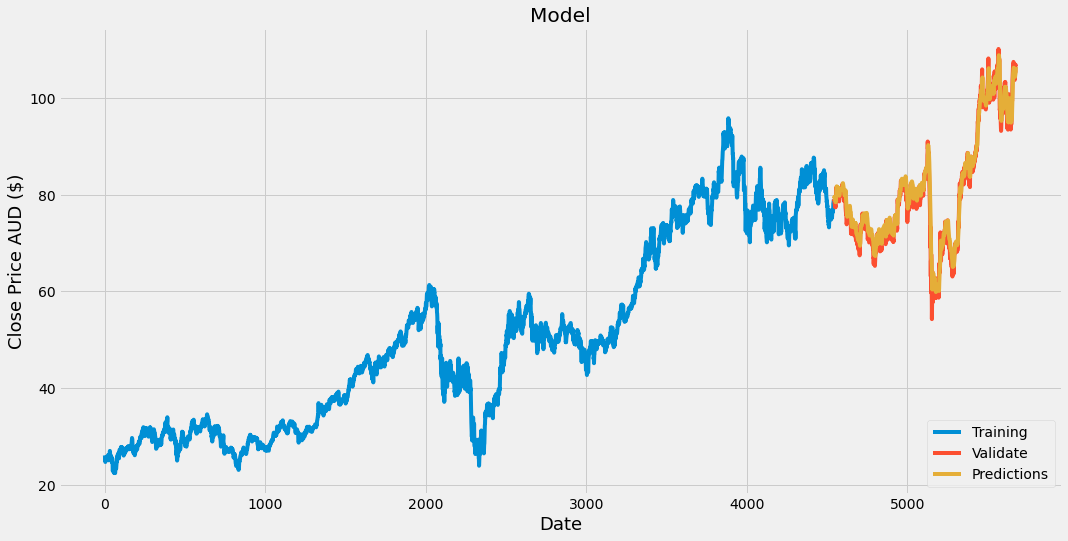

In [229]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Predictions'],loc='lower right')
plt.show()


# Test data Predictions on the Model

In [228]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_27496/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,Predictions,Difference
4542,23/10/2017,79.230003,79.360001,78.620003,78.690002,64.038857,1604897.0,NEGATIVE,79.272697,-0.582695
4543,24/10/2017,78.739998,78.949997,78.044998,78.660004,64.014442,1627596.0,NEGATIVE,79.431580,-0.771576
4544,25/10/2017,79.040001,79.279999,78.370003,78.629997,63.990025,1788933.0,NEGATIVE,79.473915,-0.843918
4545,26/10/2017,78.680000,78.989998,78.239998,78.989998,64.283005,2283904.0,POSITIVE,79.455269,-0.465271
4546,27/10/2017,79.050003,79.080002,77.820000,78.239998,63.672626,4046736.0,NEGATIVE,79.515564,-1.275566
...,...,...,...,...,...,...,...,...,...,...
5672,8/04/2022,105.650002,105.699997,104.900002,105.379997,105.379997,1740982.0,POSITIVE,104.867432,0.512565
5673,11/04/2022,105.800003,107.120003,105.750000,106.879997,106.879997,1515505.0,POSITIVE,105.097610,1.782387
5674,12/04/2022,106.790001,107.080002,106.000000,106.709999,106.709999,1334658.0,NEGATIVE,105.684570,1.025429
5675,13/04/2022,106.550003,106.900002,106.080002,106.550003,106.550003,1479813.0,NEGATIVE,106.150177,0.399826


In [15]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CBA.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR

stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']


In [16]:
# Use last 60 days price on model to predict next days price
last_60_days = stock_close_sixty[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test =np.array(X_test)
X_test =np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted next day share price {pred_price}')


NameError: name 'scaler' is not defined

In [10]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5673,14/04/2022,105.910004,107.105003,105.830002,106.5,106.5,1393778,NEGATIVE,0.05,0.08


# Save the Model

In [39]:
import joblib
filename = 'cbamodel.sav'
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://eaffd8bb-9e6f-4c87-a605-1b1e126d58d9/assets


['antoinetteboyle.sav']